# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
from csv import reader
import numpy as np
import pandas as pd
import matplotlib as plt
import math
import random
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-10 18:36:54.442429
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

EPOCHS=10
SPLITS=3
EMBED_DIMEN=16

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'

In [4]:
from cell_lines import Cell_Lines
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_number = 0
cell_line_name = all_cell_lines[cell_line_number]
print('Cell line for today:',cell_line_number,cell_line_name)

Cell line for today: 0 A549


## Load labels and sequences

In [5]:
def load_labels(atlas_file,cells):
    gene_labels = {}
    with open(atlas_file,'r') as atlas:
        header = None
        genes_considered = 0
        positives = 0
        csv = reader(atlas)
        for row in csv:
            if header is None:
                header = row
            else:
                gene = row[0]
                genes_considered += 1
                rci = float(row[1+cells])
                if not math.isnan(rci):
                    # GENERATE BINARY LABELS
                    label = 0   # RCI<0
                    if rci>=0:  # THRESHOLD
                        label = 1   #RCI>=0
                        positives += 1
                    gene_labels[gene]=label
    print('Genes:',genes_considered)
    print('Gene labels:',len(gene_labels))
    print('Positive labels:',positives)
    return gene_labels
    
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_label = load_labels(atlas_path,cell_line_number)

2022-10-10 18:37:13.915065
Genes: 14216
Gene labels: 10392
Positive labels: 5412


In [6]:
def load_sequences(gencode_file,gene_label):
    gid_tid = []
    labels = []
    tseqs = []
    with open(gencode_file,'r') as gencode:
        header = None
        csv = reader(gencode)
        for row in csv:
            if header is None:
                header = row
            else:
                tran_id = row[0]
                gene_id = row[1]
                tseq = row[4]
                if gene_id in gene_label:
                    label = gene_label[gene_id]
                    gid_tid.append ((gene_id,tran_id))
                    labels.append(label)
                    tseqs.append(tseq)
    return gid_tid,labels,tseqs

In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
ordered_gid_tid,ordered_labels,ordered_seqs = \
    load_sequences(gencode_path,gene_label)

2022-10-10 18:37:14.008341


## Make K-mers

In [8]:
print(datetime.now())
ordered_kmer_counts = []
tock = 1000
tick = 0
for seq in ordered_seqs:
    tick += 1
    if tick >= tock:
        tick = 1
        print('.',end='')
    counts = counter.seq_to_kmer_counts(seq)
    ordered_kmer_counts.append(counts)
print(datetime.now())

2022-10-10 18:37:15.571899
.....................................................2022-10-10 18:44:08.205541


## Build model

In [9]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [17]:
from random import Random
num_transcripts = len(ordered_gid_tid)
gene_set = set()
for (gid,tid) in ordered_gid_tid:
    gene_set.add(gid)
num_genes = len(gene_set)
print('Num genes:',num_genes,'Num transcripts:',num_transcripts)
gene_list = list(gene_set)
generator = Random()
generator.seed(42)
generator.shuffle(gene_list)  # in-place
def train_valid_split(iteration, partitions):
    partition_size = int(num_genes * 1.0/partitions)
    low = int(iteration*partition_size)
    high = int(low+partition_size)    
    valid_genes = set(gene_list[low:high])
    X_train = []   # would be more efficient with fixed-size numpy array
    X_valid = []
    y_train = []
    y_valid = []
    for i in range(num_transcripts):
        (gid,tid) = ordered_gid_tid[i]     
        if gid in valid_genes:
            X_valid.append(ordered_kmer_counts[i])   
            y_valid.append(ordered_labels[i])
        else:
            X_train.append(ordered_kmer_counts[i])   
            y_train.append(ordered_labels[i])
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_valid = np.asarray(X_valid)
    y_valid = np.asarray(y_valid)
    return X_train,y_train,X_valid,y_valid

Num genes: 10268 Num transcripts: 53450


In [18]:
import matplotlib.pyplot as plt 
def do_cross_validation(X,y,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    # PARTITIONS=1   # for testing
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        # this is complaining about string to float
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Train

2022-10-10 18:58:54.010140
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
None
Sequence to Kmer
Cross valiation
Fold 0
Train set ones/size 21640 / 42774
Valid set ones/size 5323 / 10676


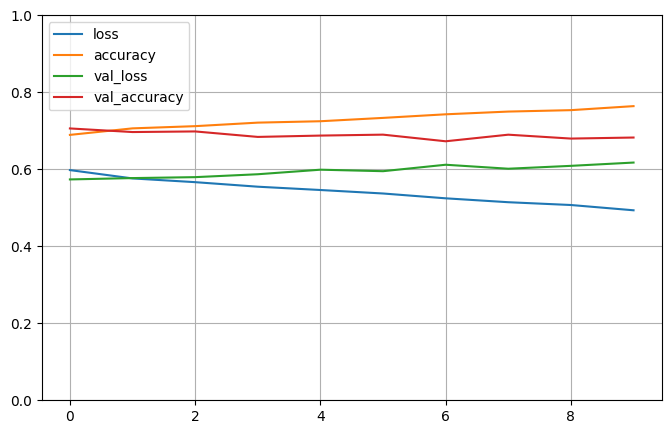

accuracy: 68.25%
Fold 1
Train set ones/size 21688 / 42894
Valid set ones/size 5275 / 10556
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1341/1341 [==============================] - 5s 3ms/step - loss: 0.5936 - accuracy: 0.6909 - val_loss: 0.5983 - val_accuracy: 0.6879
Epoch 2/10
1341/1341 [==============================] - 4s 3ms/step - loss: 0.5771 - accuracy: 0.7040 - val_loss: 0.5798 - val_accuracy: 0.7019
Epoch 3/10
1341/1341 [==============================] - 4s 3ms/step - loss: 0.5688 - accuracy: 0.7125 - val_loss: 0.5914 - val_accuracy: 0.6995
Epoch 4/10
1341/1341 [==============================] - 4s 3ms/step - loss: 0.5599 - accuracy: 0.7180 - val_loss: 0.5942 - val_accuracy: 0.6991
Epoch 5/10
1341/1341 [==============================] - 4s 3ms/step - loss: 0.5485 - accuracy: 0.7230 - val_loss: 0.5850 - val_accuracy: 0.7057
Epoch 6/10
1341/1341 [==============================] - 4s 3ms/step - loss: 0.5368 - accuracy: 0.7337 - val_loss: 0.5925 - val_accuracy: 0.7005
Epoch 

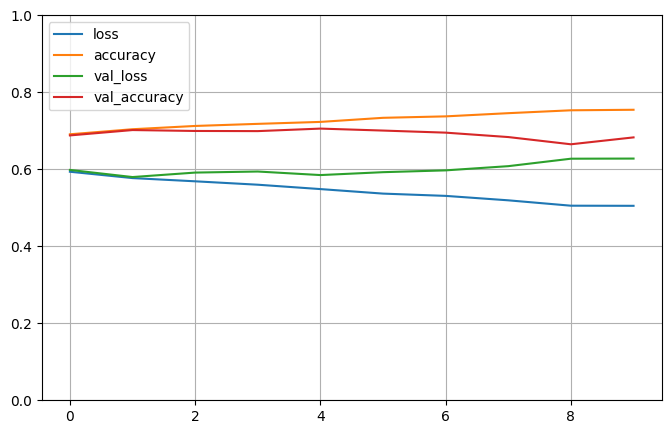

accuracy: 68.28%
Fold 2
Train set ones/size 21249 / 42555
Valid set ones/size 5714 / 10895
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1330/1330 [==============================] - 5s 3ms/step - loss: 0.5938 - accuracy: 0.6903 - val_loss: 0.6043 - val_accuracy: 0.6824
Epoch 2/10
1330/1330 [==============================] - 4s 3ms/step - loss: 0.5719 - accuracy: 0.7083 - val_loss: 0.6025 - val_accuracy: 0.6821
Epoch 3/10
1330/1330 [==============================] - 4s 3ms/step - loss: 0.5641 - accuracy: 0.7132 - val_loss: 0.6056 - val_accuracy: 0.6811
Epoch 4/10
1330/1330 [==============================] - 4s 3ms/step - loss: 0.5514 - accuracy: 0.7200 - val_loss: 0.6059 - val_accuracy: 0.6767
Epoch 5/10
1330/1330 [==============================] - 4s 3ms/step - loss: 0.5407 - accuracy: 0.7293 - val_loss: 0.6176 - val_accuracy: 0.6744
Epoch 6/10
1330/1330 [==============================] - 4s 3ms/step - loss: 0.5279 - accuracy: 0.7370 - val_loss: 0.6349 - val_accuracy: 0.6716
Epoch 

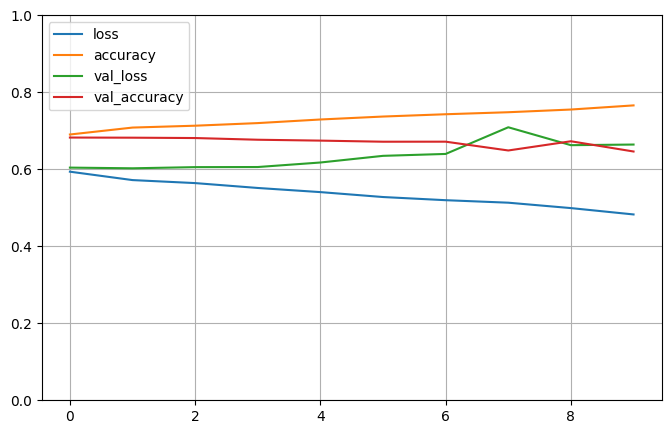

accuracy: 64.62%
Fold 3
Train set ones/size 21814 / 42779
Valid set ones/size 5149 / 10671
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5954 - accuracy: 0.6884 - val_loss: 0.6004 - val_accuracy: 0.6827
Epoch 2/10
1337/1337 [==============================] - 7s 5ms/step - loss: 0.5752 - accuracy: 0.7073 - val_loss: 0.6075 - val_accuracy: 0.6824
Epoch 3/10
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5627 - accuracy: 0.7168 - val_loss: 0.6020 - val_accuracy: 0.6824
Epoch 4/10
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5513 - accuracy: 0.7231 - val_loss: 0.6330 - val_accuracy: 0.6736
Epoch 5/10
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5394 - accuracy: 0.7337 - val_loss: 0.6176 - val_accuracy: 0.6758
Epoch 6/10
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5285 - accuracy: 0.7409 - val_loss: 0.6266 - val_accuracy: 0.6719
Epoch 

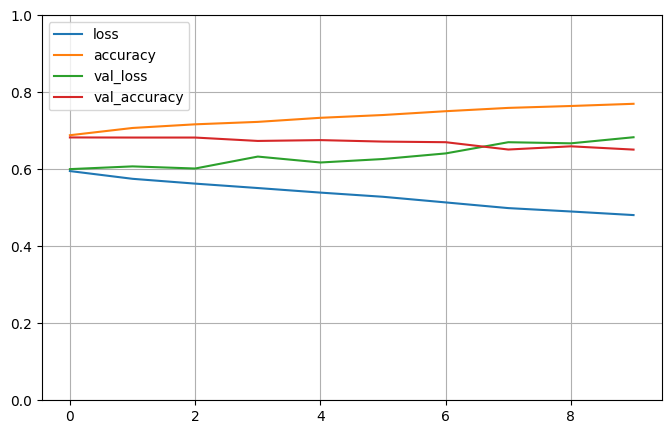

accuracy: 65.11%
Fold 4
Train set ones/size 21462 / 42809
Valid set ones/size 5501 / 10641
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1338/1338 [==============================] - 4s 3ms/step - loss: 0.5935 - accuracy: 0.6926 - val_loss: 0.5913 - val_accuracy: 0.6936
Epoch 2/10
1338/1338 [==============================] - 5s 3ms/step - loss: 0.5747 - accuracy: 0.7071 - val_loss: 0.5994 - val_accuracy: 0.6888
Epoch 3/10
1338/1338 [==============================] - 4s 3ms/step - loss: 0.5639 - accuracy: 0.7155 - val_loss: 0.5941 - val_accuracy: 0.6963
Epoch 4/10
1338/1338 [==============================] - 4s 3ms/step - loss: 0.5519 - accuracy: 0.7220 - val_loss: 0.6053 - val_accuracy: 0.6947
Epoch 5/10
1338/1338 [==============================] - 4s 3ms/step - loss: 0.5432 - accuracy: 0.7282 - val_loss: 0.6068 - val_accuracy: 0.6770
Epoch 6/10
1338/1338 [==============================] - 3s 3ms/step - loss: 0.5297 - accuracy: 0.7376 - val_loss: 0.6171 - val_accuracy: 0.6970
Epoch 

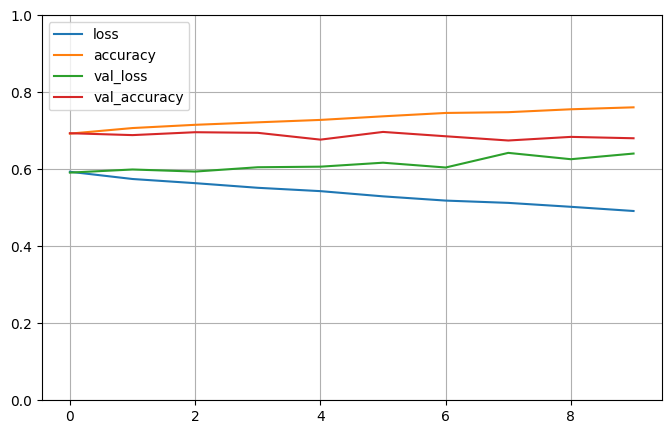

accuracy: 68.06%

Validation core mean 66.86% (+/- 1.64%)
2022-10-10 19:02:14.506223


In [19]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Sequence to Kmer")
y = ordered_labels
X = ordered_kmer_counts

print ("Cross valiation")
do_cross_validation(X,y,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 